# Hidden Markov Model
## 1. Theory

Sources: 
- https://www.scirp.org/journal/paperinformation?paperid=82940#:~:text=For%20stock%20traders%2C%20promptly%20predicting,%E2%80%9D%2C%20or%20%E2%80%9CMedium%E2%80%9D.
- https://www.youtube.com/watch?v=9-sPm4CfcD0

Hidden Markov Models are statistical models that predict observable states using hidden states.

Ex. You have three weather patterns: cloudy, sunny, and rainy. They each have their own unique probabilities and patterns. However, suppose we live in a different city, and we cannot see the weather for ourselves. Instead, we have a friend who lives there. Their mood is influenced by the weather, ie. different probabilities of happy or sad based on the cloudy, rainy, and sunny patterns. 

We compute the joint probability of our friend's mood patterns and their city's weather patterns. Maximizing this joint probability gives us the most likely weather sequence given the observed mood sequence. 

$$\underset{X = X_1, X_2, ..., X_n}{\operatorname{argmax}} P(X = X_1, X_2, ..., X_n) | Y = Y_1, Y_2, ... Y_n)
$$

This is difficult to find, so we use Bayes' Theorem.
$$\underset{X = X_1, X_2, ..., X_n}{\operatorname{argmax}} P(Y | X)P(X) / P(Y)
$$

$$\underset{X = X_1, X_2, ..., X_n}{\operatorname{argmax}} \Pi P(Y_i | X_i)P(X_i|X_{i-1})$$


## 2. Objective
We apply the same concept to predicting stock trends. Our hidden states of prediction are uptrend, downtrend, and flat-trend. Our observable states are the prices, volumes, etc.

In [1]:
#import sys
#print(sys.executable)
#!{sys.executable} -m pip install numpy pandas hmmlearn yfinance matplotlib
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Fetch and preprocess data
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, interval="60m")
    data.columns = data.columns.get_level_values(0)  # Flatten columns
    data['Returns'] = data['Close'].pct_change()
    data = data.dropna()
    return data

# Step 2: Prepare features
def prepare_features(data):
    data['Volatility'] = data['Returns'].rolling(window=5).std()
    features = data[['Returns', 'Volatility']].dropna().values  # 2D array
    aligned_data = data.dropna(subset=['Returns', 'Volatility'])  # Align with features
    return aligned_data, features

# Step 3: Train HMM
def train_hmm(features, n_states):
    print("Training HMM with features shape:", features.shape)
    model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000, random_state=42)
    model.fit(features) 
    hidden_states = model.predict(features) # shoudl it fit and predict on the same features?
    return model, hidden_states

# Step 4: Plot hidden states
def plot_hidden_states(data, hidden_states, n_states):
    plt.figure(figsize=(15, 8))
    plt.plot(data.index, data['Close'], color='gray', alpha=0.5, label="Stock Price")
    state_colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']
    state_colors = state_colors[:n_states]
    for state in range(n_states):
        state_indices = (hidden_states == state)
        plt.scatter(data.index[state_indices], data['Close'][state_indices], 
                    color=state_colors[state], label=f"State {state}", s=10)
    plt.title("Stock Price by Hidden States")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

# Step 5: Analyze hidden states
def analyze_hidden_states(data, hidden_states, n_states):
    state_info = []
    for state in range(n_states):
        state_data = data[hidden_states == state]
        avg_return = state_data['Returns'].mean()
        avg_volatility = state_data['Volatility'].mean()
        state_info.append((state, avg_return, avg_volatility))
        print(f"State {state}:")
        print(f"  Average Return: {avg_return:.4f}")
        print(f"  Average Volatility: {avg_volatility:.4f}")
    return state_info

# Step 6: Simulate trading
def simulate_trading(data, hidden_states, state_info):
    data['State'] = hidden_states
    # Determine the state with the highest average return as the uptrend state
    uptrend_state = max(state_info, key=lambda x: x[1])[0]
    data['Signal'] = data['State'].apply(lambda x: 1 if x == uptrend_state else -1)
    data['Strategy Returns'] = data['Signal'].shift(1) * data['Returns']
    cumulative_strategy_returns = (1 + data['Strategy Returns'].dropna()).cumprod()
    cumulative_market_returns = (1 + data['Returns'].dropna()).cumprod()
    plt.figure(figsize=(15, 8))
    plt.plot(cumulative_strategy_returns, label="Strategy Returns")
    plt.plot(cumulative_market_returns, label="Market Returns")
    plt.legend()
    plt.title("Trading Strategy vs. Market")
    plt.show()

# Step 7: Calculate metrics
def calculate_metrics(data):
    data['Actual_Movement'] = (data['Returns'] > 0).astype(int)
    data['Predicted_Movement'] = (data['State'] == 0).astype(int)
    true_positives = sum((data['Actual_Movement'] == 1) & (data['Predicted_Movement'] == 1))
    false_positives = sum((data['Actual_Movement'] == 0) & (data['Predicted_Movement'] == 1))
    true_negatives = sum((data['Actual_Movement'] == 0) & (data['Predicted_Movement'] == 0))
    false_negatives = sum((data['Actual_Movement'] == 1) & (data['Predicted_Movement'] == 0))
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    accuracy = (true_positives + true_negatives) / len(data)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print("\nModel Performance Metrics:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1 Score: {f1_score:.3f}")
    print("\nConfusion Matrix:")
    print(f"True Positives: {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"True Negatives: {true_negatives}")
    print(f"False Negatives: {false_negatives}")


In [2]:
ticker = "AAPL"
from datetime import datetime, timedelta
end_date = datetime.now()
start_date = end_date - timedelta(days=250)

# Fetch and preprocess data
stock_data = fetch_stock_data(ticker, start_date, end_date)

# Prepare features
aligned_data, features = prepare_features(stock_data)

# Train HMM
n_states = 3
hmm_model, hidden_states = train_hmm(features, n_states)




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Training HMM with features shape: (1191, 2)


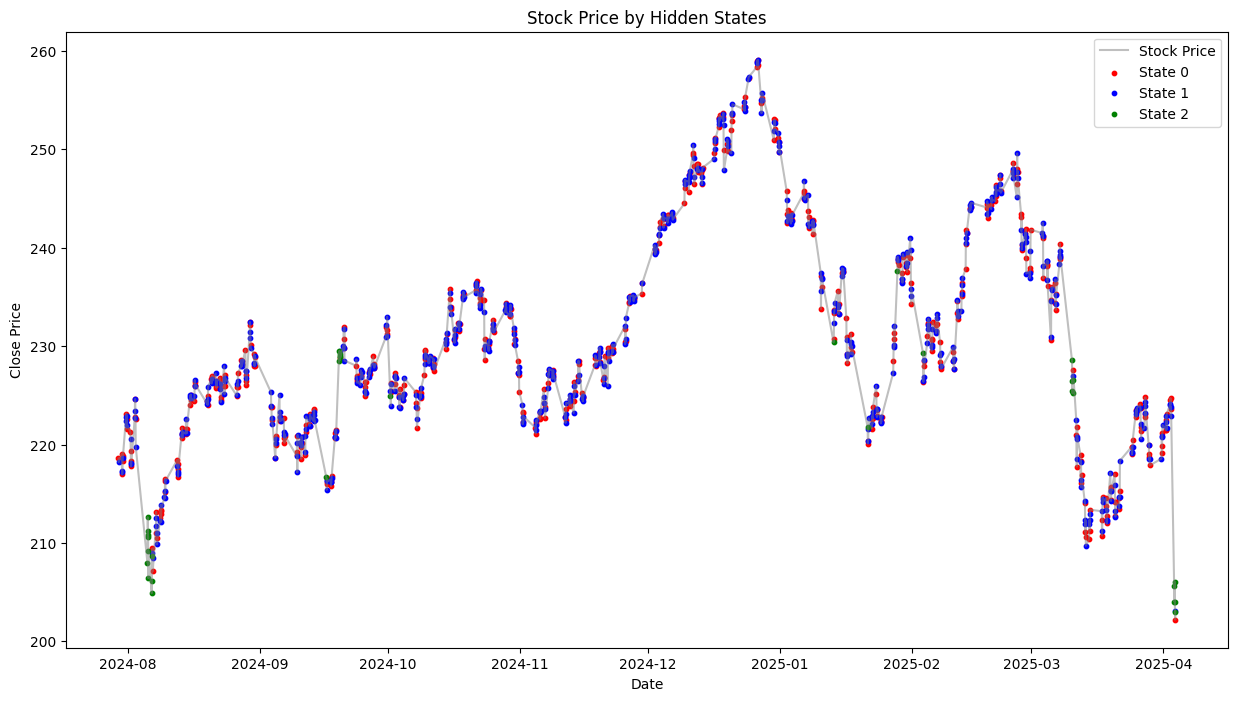

In [3]:
plot_hidden_states(aligned_data, hidden_states, n_states)


In [4]:
print("Hidden states shape:", hidden_states.shape)  
# Plot Hidden States 
aligned_data = aligned_data.copy()  
aligned_data['State'] = hidden_states
aligned_data['Signal'] = aligned_data['State'].apply(lambda x: 1 if x == 0 else -1)  # Buy in state 0, sell in others
aligned_data['Strategy Returns'] = aligned_data['Signal'].shift(1) * aligned_data['Returns']
calculate_metrics(aligned_data)

Hidden states shape: (1191,)

Model Performance Metrics:
Precision: 0.523
Recall: 0.486
Accuracy: 0.500
F1 Score: 0.504

Confusion Matrix:
True Positives: 302
False Positives: 275
True Negatives: 294
False Negatives: 320


State 0:
  Average Return: -0.0000
  Average Volatility: 0.0046
State 1:
  Average Return: 0.0004
  Average Volatility: 0.0048
State 2:
  Average Return: -0.0090
  Average Volatility: 0.0211


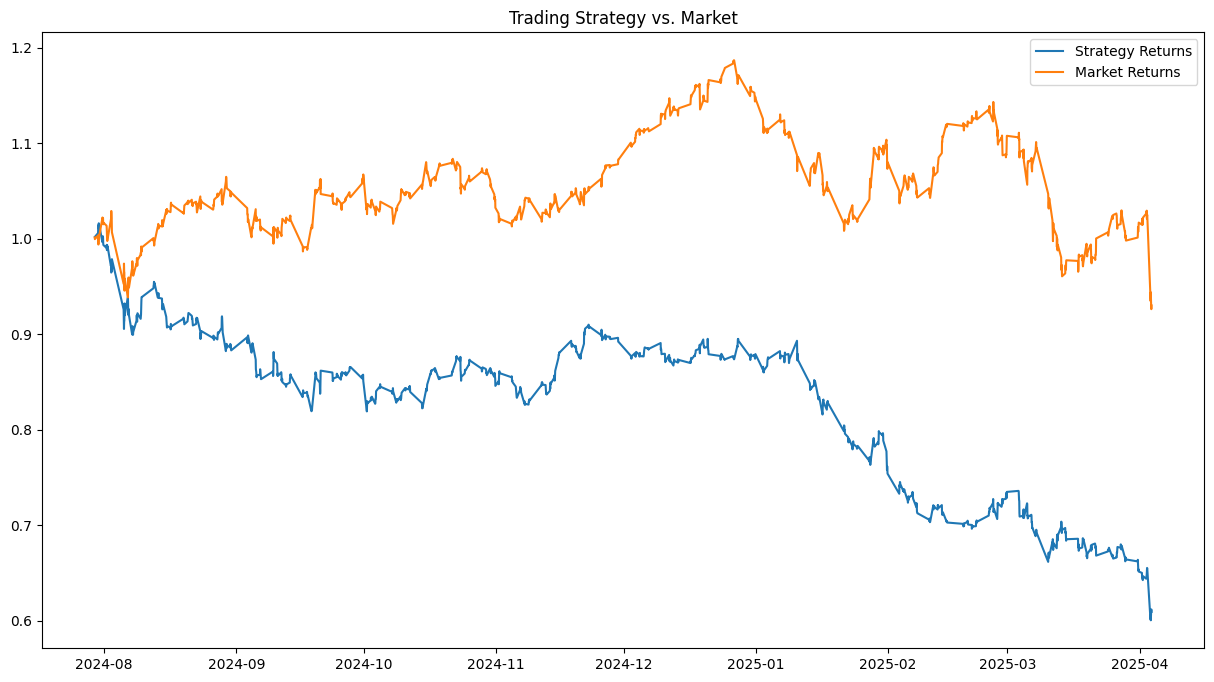

In [5]:
state_info = analyze_hidden_states(aligned_data, hidden_states, n_states)
# Simulate Trading Strategy 
simulate_trading(aligned_data, hidden_states, state_info)

## Key Findings
